In [ ]:
print("Start")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import gymnasium as gym
from stable_baselines3 import PPO

Start


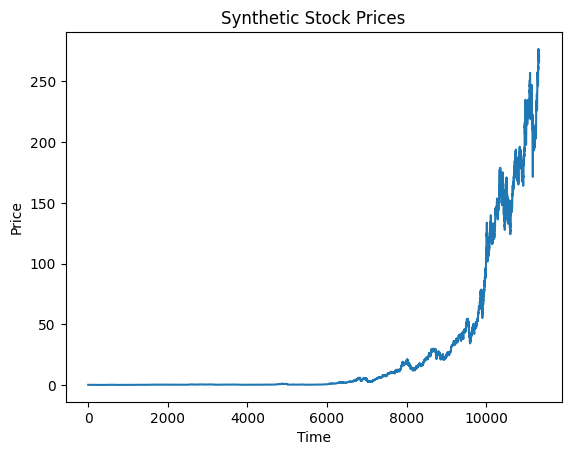

In [4]:
CSV_PATH = "lstm/data/AAPL.csv"
TARGET_COL = "Open"
df = pd.read_csv(CSV_PATH)

plt.plot(df["Open"])
plt.title("Synthetic Stock Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [14]:
df["Open_log_return"] = np.log(df["Open"] / df["Open"].shift(1))
df["Open_log_return"] = df["Open_log_return"].fillna(0.0)
combined_prices_scaled_df = df["Open_log_return"].to_frame()

In [16]:
print(type(combined_prices_scaled_df))
print(type(df))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:

class StockTradingEnv(gym.Env):
    metadata = {'render_modes': ['human'], 'render_fps': 30}

    def __init__(self, df_scaled, original_df, initial_balance=10000, trade_fee_pct=0.01):
        super().__init__()
        self.action_map = {
            0: ("HOLD", 0),
            1: ("BUY", 1),
            2: ("BUY", 5),
            3: ("BUY", 10),
            4: ("SELL", 1),
            5: ("SELL", 5),
            6: ("SELL", 10),
            }
        
        self.action_space = gym.spaces.Discrete(len(self.action_map))
        self.df_scaled = df_scaled 
        self.original_df = original_df 

        self.initial_balance = initial_balance
        self.trade_fee_pct = trade_fee_pct 

        self.balance = self.initial_balance 
        self.shares_held = 0 
        self.net_worth = self.initial_balance 
        self.last_net_worth = self.initial_balance 
        self.current_step = 0
        self.max_steps = len(df_scaled) - 1
        
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(self._get_observation()),), dtype=np.float32)


    def _get_observation(self):
        market_obs = self.df_scaled.iloc[self.current_step].values.astype(np.float32)
        current_price = self._get_current_price()
        net_worth = self.net_worth if self.net_worth > 0 else 1.0
        position_flag = 1.0 if self.shares_held > 0 else 0.0
        position_value = self.shares_held * current_price
        position_ratio = position_value / net_worth
        cash_ratio = self.balance / net_worth
        obs_space = np.array([
                    position_flag,
                    position_ratio,
                    cash_ratio
                ], dtype=np.float32)
        # Udawany LSTM
        if self.current_step < len(self.original_df) - 1:
            pred_price = self.original_df['Open'].iloc[self.current_step + 1]
        else:
            pred_price = current_price
        lstm_obs= np.array([(pred_price-current_price)/current_price], dtype=np.float32)
        return np.concatenate([market_obs, obs_space, lstm_obs])

    def _get_current_price(self):
        return self.original_df['Open'].iloc[self.current_step]

    def _take_action(self, action):
        current_price = self._get_current_price()
        action_type, stocks_count = self.action_map[action]

        if action_type == "BUY":  
            available_cash_for_shares = self.balance / (1 + self.trade_fee_pct)

            max_affordable_shares = int(available_cash_for_shares // current_price) if current_price > 0 else 0
            if stocks_count>=max_affordable_shares:
                num_shares_to_buy = max_affordable_shares
            else:
                num_shares_to_buy = min(stocks_count, max_affordable_shares)

            if num_shares_to_buy > 0:
                cost = num_shares_to_buy * current_price * (1 + self.trade_fee_pct)
                self.shares_held += num_shares_to_buy
                self.balance -= cost

        elif action_type == "SELL":  
            if stocks_count >= self.shares_held:
                num_shares_to_sell = int(self.shares_held)
            else:
                num_shares_to_sell = min(stocks_count, int(self.shares_held))

            if num_shares_to_sell > 0:
                proceeds = num_shares_to_sell * current_price * (1 - self.trade_fee_pct)
                self.balance += proceeds
                self.shares_held -= num_shares_to_sell
        elif action_type == "HOLD": 
            pass
        
        self.net_worth = self.balance + (self.shares_held * current_price)

    def _get_reward(self):
        reward = self.net_worth - self.last_net_worth
        self.last_net_worth = self.net_worth
        return reward

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.last_net_worth = self.initial_balance
        self.current_step = 0

        observation = self._get_observation()
        info = {}
        return observation, info

    def step(self, action):
        self.last_net_worth = self.net_worth 
        self._take_action(action)

        reward = self._get_reward()

        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        truncated = False 

        observation = self._get_observation() if not terminated else np.zeros_like(self._get_observation())
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        if mode == 'human':
            print(f"Step: {self.current_step}")
            print(f"Balance: {self.balance:.2f}")
            print(f"Price: {self._get_current_price():.2f}")

In [32]:
env = StockTradingEnv(
    df_scaled=combined_prices_scaled_df,
    original_df=df,
    initial_balance=100,
    trade_fee_pct=0.001
)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 432  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 355         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010380328 |
|    clip_fraction        | 0.0206      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -0.00937    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.364       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00234    |
|    value_loss         

In [ ]:
obs, _ = env.reset()
done = False

buys_x=[]
buys_y=[]
sells_x=[]
sells_y=[]
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(int(action))
    if action in [1,2,3]:
        buys_x.append(env.current_step)
        buys_y.append(env._get_current_price())
    if action in [4,5,6]:
        sells_x.append(env.current_step)
        sells_y.append(env._get_current_price())    
    if terminated:
        break



In [34]:
print("Total profit:", env.balance)

Total profit: 42.30578241717526


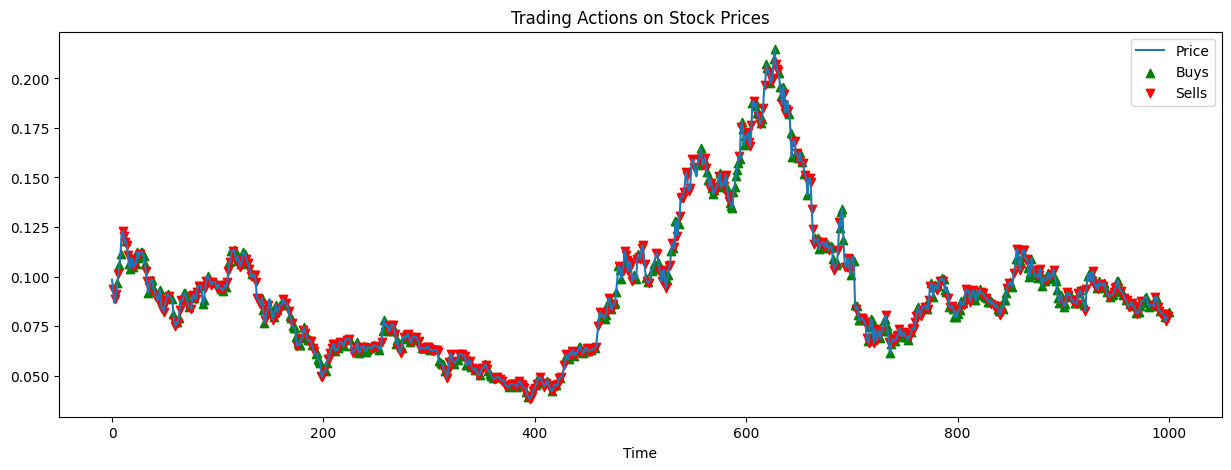

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df["Open"][0:1000], label="Price")
ax.scatter(buys_x, buys_y, marker="^", color="g", label="Buys")
ax.scatter(sells_x, sells_y, marker="v", color="r", label="Sells")
ax.set_title("Trading Actions on Stock Prices")
ax.set_xlabel("Time")
ax.legend()
plt.show()
